# Usable Data Map (UDM2) Cloud Detection within an AOI

This guide is a follow up to the [UDM2 Cloud Detection](udm2_clouds.ipynb) notebook. Please refer to that notebook for further details on specifications and usage of the UDM2 asset. In this notebook, we apply cloud detection to a specific area of interest (AOI).

The `udm2` asset is available for all `PSScene4Band` and `PSOrthoTile` items created after 2018-08-01. Therefore, our search should be limited to these items and this date range.

## Finding clear imagery

One of the benefits of accurate and automated cloud detection is that it allows users to filter out images that don't meet a certain quality threshold. Planet's Data API allows users to [search](https://developers.planet.com/docs/api/searches-filtering/) based on the value of the imagery metadata.

For example, if you are using the Planet command-line tool, you can search for all four-band PlanetScope scenes that have less than 10% cloud cover in them with the following:

    planet data search --item-type PSScene4Band --range cloud_percent lt 10
    
Planet's cloud detection algorithm classifies every pixel into one of six different categories, each of which has a corresponding metadata field that reflects the percentage of data that falls into the category.

| Class | Metadata field |
| --- | --- |
| clear | `clear_percent` |
| snow | `snow_ice_percent` |
| shadow | `shadow_percent` |
| light haze | `light_haze_percent` |
| heavy haze| `heavy_haze_percent` |
| cloud | `cloud_percent` |

These can be combined to refine search results even further. An example of searching for imagery that has less than 10% clouds and less than 10% heavy haze:

    planet data search --item-type PSScene4Band --range cloud_percent lt 10 --range heavy_haze_percent lt 10
    
Every pixel will be classified into only one of the categories above; a pixel may be snowy or obscured by a shadow but it can not be both at the same time!

The following example will show how to do a search for imagery that is at least 90% clear, within a date range, and within an AOI, using Planet's Python client.

In [43]:
import datetime
import json
import os
import time

from planet import api
from planet.api import filters
import rasterio
from rasterio.plot import show

In [26]:
# define the date range for imagery
start_date = datetime.datetime(year=2019,month=4,day=1)
stop_date = datetime.datetime(year=2019,month=5,day=1)

# define the aoi for imagery
aoi = {"geometry": {
    "type":"Polygon",
    "coordinates":
        [[
            [25.42429478260258,1.0255377823058893],
            [25.592960813580472,1.0255377823058893],
            [25.592960813580472,1.1196578801254304],
            [25.42429478260258,1.1196578801254304],
            [25.42429478260258,1.0255377823058893]
        ]]}}


item_type = 'PSOrthoTile'

In [58]:
def build_ps_request(item_type, aoi_geom, start_date, stop_date):
    query = filters.and_filter(
        filters.geom_filter(aoi_geom),
        filters.range_filter('clear_percent', gte=70),
        filters.range_filter('clear_percent', lte=95),
        filters.date_range('acquired', gt=start_date),
        filters.date_range('acquired', lt=stop_date)
    )

    return filters.build_search_request(query, [item_type])

request = build_ps_request(item_type, aoi['geometry'], start_date, stop_date)
print(request)

{'item_types': ['PSOrthoTile'], 'filter': {'type': 'AndFilter', 'config': ({'field_name': 'geometry', 'type': 'GeometryFilter', 'config': {'type': 'Polygon', 'coordinates': [[[25.42429478260258, 1.0255377823058893], [25.592960813580472, 1.0255377823058893], [25.592960813580472, 1.1196578801254304], [25.42429478260258, 1.1196578801254304], [25.42429478260258, 1.0255377823058893]]]}}, {'field_name': 'clear_percent', 'type': 'RangeFilter', 'config': {'gte': 70}}, {'field_name': 'clear_percent', 'type': 'RangeFilter', 'config': {'lte': 95}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'gt': '2019-04-01T00:00:00Z'}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'lt': '2019-05-01T00:00:00Z'}})}}


In [59]:
def get_api_key():
    return os.environ['PL_API_KEY']

# quick check that key is defined
assert get_api_key(), "PL_API_KEY not defined."

def create_client():
    return api.ClientV1(api_key=get_api_key())

def search_pl_api(request, limit=500):
    client = create_client()
    result = client.quick_search(request)
    
    # note that this returns a generator
    return result.items_iter(limit=limit)

items = list(search_pl_api(request))
print(len(items))
# uncomment below to see entire metadata for a PS orthotile
# print(json.dumps(items[0], indent=4))

14


In [60]:
item_id = items[0]['id']
item_id

'2310711_3539508_2019-04-25_1035'

## The `udm2` asset

In addition to metadata for filtering, the `udm2` asset provides a pixel-by-pixel map that identifies the classification of each pixel.

In the example below, cloudy pixels are highlighted in yellow, shadows in red and light haze in blue.

| Original image | `udm2` overlay |
| :--- | :--- |
| ![20190228_172942_0f1a_3B_Visual.tif](assets/20190228_172942_0f1a_orig.png) |  ![Detected clouds](assets/20190228_172942_0f1a_map.png) |
| `20190228_172942_0f1a_3B_Visual.tif` | `20190228_172942_0f1a_udm2.tif` |

The `udm2` structure is to use a separate band for each classification type. Band 2, for example, indicates that a pixel is snowy when its value is 1, band 3 indicates shadow and so on. 

The following Python will download the data above and then display pixels that fall into a certain classifications.

In [61]:
# activate assets
assets = client.get_assets_by_id(item_type, item_id).get()
client.activate(assets["analytic"])
client.activate(assets["udm2"])

# wait until activation completes
while True:
    assets = client.get_assets_by_id(item_type, item_id).get()
    if "location" in assets["analytic"] and "location" in assets["udm2"]:
        print('assets activated')
        break
    time.sleep(10)    

assets activated


In [62]:
# start downloads
data_dir = 'data'
r1 = client.download(assets["analytic"], callback=api.write_to_file(data_dir))
r2 = client.download(assets["udm2"], callback=api.write_to_file(data_dir))

`background_callback` is deprecated and will be removed in 1.0, use `hooks` instead
`background_callback` is deprecated and will be removed in 1.0, use `hooks` instead


In [63]:
# wait until downloads complete
r1.wait()
r2.wait()
img_file = os.path.join(data_dir, r1.get_body().name)
udm_file = os.path.join(data_dir, r2.get_body().name)
print("image: {}".format(img_file))
print("udm2:  {}".format(udm_file))

image: data/2310711_3539508_2019-04-25_1035_BGRN_Analytic.tif
udm2:  data/2310711_3539508_2019-04-25_1035_udm2.tif


### Visualize Image and UDM2

In [64]:
with rasterio.open(udm_file) as src:
    print(src.width)
    print(src.height)
    shadow_mask = src.read(3).astype(bool)
    cloud_mask = src.read(6).astype(bool)

8000
8000


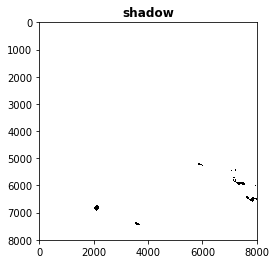

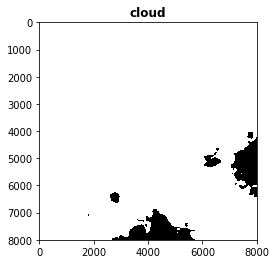

In [65]:
show(shadow_mask, title="shadow", cmap="binary")
show(cloud_mask, title="cloud", cmap="binary")

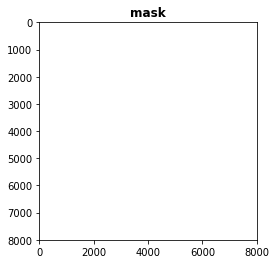

In [47]:
mask = shadow_mask + cloud_mask
show(mask, title="mask", cmap="binary")

In [48]:
with rasterio.open(img_file) as src:
    profile = src.profile
    img_data = src.read([3, 2, 1], masked=True) / 10000.0 # apply RGB ordering and scale down

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


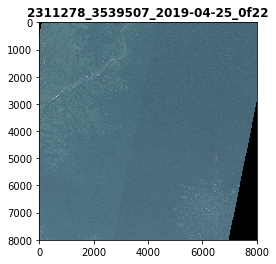

In [49]:
show(img_data, title=item_id)

In [50]:
img_data.mask = mask
img_data = img_data.filled(fill_value=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


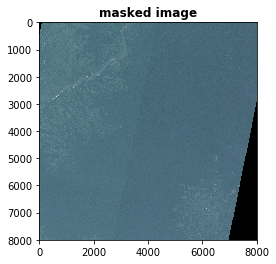

In [51]:
show(img_data, title="masked image")

The image stored in `img_data` now has cloudy pixels masked out and can be saved or used for analysis.